In [ ]:
#Create pretty maps for street view project following 
#http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vx2fYZMrKL_

In [386]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from itertools import chain
from descartes import PolygonPatch
from pysal.esda.mapclassify import Natural_Breaks as nb
from shapely.geometry import Polygon
import fiona
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from lxml import etree
import csv
import os
import locale
from matplotlib import gridspec
import matplotlib.colors as mcolors
%matplotlib inline

In [ ]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, discretize, labels=None, max_label=None, min_label=None,**kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    if discretize:
        cmap = cmap_discretize(cmap, ncolors)
        max_label=ncolors
        min_label=0
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(min_label, max_label)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(min_label, max_label, ncolors))
    colorbar.set_ticklabels(np.linspace(min_label,max_label,ncolors))
    colorbar.ax.tick_params(labelsize=20) 
    colorbar.ax.tick_params(color='#808080')
    colorbar.outline.set_linewidth(2)
    colorbar.outline.set_edgecolor('#808080')
    if labels:
        colorbar.set_ticklabels(labels)


    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

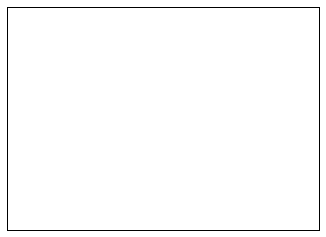

In [385]:
city_bounds=np.loadtxt('/afs/cs.stanford.edu/u/tgebru/cars/ipython_code/data/cityids_bounds.txt',
                      delimiter=',')
#for city in xrange(city_bounds.size):
city=179
cityid=int(city_bounds[city,0])
ll=(city_bounds[city,4],city_bounds[city,2])
ur=(city_bounds[city,3],city_bounds[city,1])
coords=list(chain(ll,ur))
w,h=coords[2]-coords[0],coords[3]-coords[1]
extra=0.05
#The center lat, longs for the city
lon_0=0.5*(city_bounds[city,3]+city_bounds[city,4])#+3*w
lat_0=0.5*(city_bounds[city,1]+city_bounds[city,2])-h

'''SF
llcrnrlon=coords[0] + 15.5*extra * w,
    llcrnrlat=coords[1]+ 5*extra * h,
    urcrnrlon=coords[2]- extra * w,
    urcrnrlat=coords[3]- 7*extra * h,
'''
m = Basemap(
    projection='tmerc',
    lon_0=lon_0,
    lat_0=lat_0,
    lat_ts=0,
    llcrnrlon=coords[0]+ 15.5*extra * w,
    llcrnrlat=coords[1]+ 3*extra * h,
    urcrnrlon=coords[2]- extra * w,
    urcrnrlat=coords[3]- 10*extra * h,
    ellps = 'WGS84',
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'data/science/voting_result_4326',
    'us',
    color='none',
    zorder=2)

# set up a map dataframe
all_df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.us],
    'precinct': [precinct['precincts'] for precinct in m.us_info]})

In [365]:
int(city_bounds[24,0])

137

In [387]:
#Get voting results for each precinct
voting_dict={}
info_dir='/scail/scratch/u/tgebru/gsv_classify/analysis/demo/results/predictions'
info_file='unfiltered.dem_frac.PRECINCT.glm.0.no.5.ni.1.rc.1.minp.500.minc.50.cp.1.train-10.whole_country.0.prev.1.manhat.0.txt'

lines=open(os.path.join(info_dir,info_file),'rb').readlines()
for l in lines:
  precinct=l.split(',')[0].strip()
  if 'precinct' in voting_dict:
      voting_dict['precinct'].append(int(precinct))
  else: 
      voting_dict['precinct']=[int(precinct)]
  if 'actual_dem' in voting_dict:
      voting_dict['actual_dem'].append(float(l.split(',')[1].strip()))
  else:
      voting_dict['actual_dem'] = [float(l.split(',')[1].strip())]
  if 'predicted_dem' in voting_dict:
      voting_dict['predicted_dem'].append(float(l.split(',')[2].strip()))

  else:
      voting_dict['predicted_dem']=[float(l.split(',')[2].strip())]

voting=pd.DataFrame(voting_dict)
all_df_map = all_df_map.merge(voting)

#Get precincts for each of the 200 cities and map boundaries
city_precincts=np.loadtxt('/scail/scratch/u/tgebru/gsv_classify/analysis/demo/files/precinct_city.txt',
                     delimiter='\t',dtype='int')
cityids=np.unique(city_precincts[:,1])
cur_prec_inds=np.where(city_precincts[:,1]==cityid)
cur_precincts=city_precincts[cur_prec_inds[0],0]
df_cur_prec = pd.DataFrame({'precinct': cur_precincts})
df_map = all_df_map.merge(df_cur_prec)

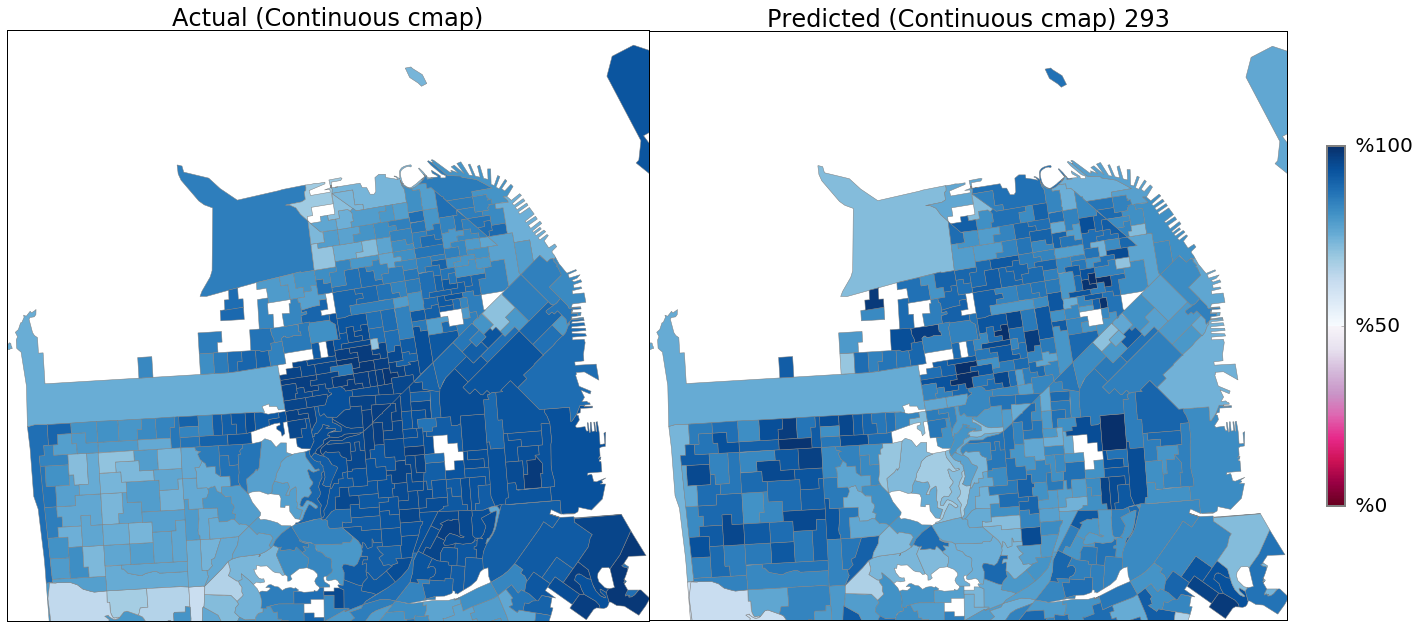

In [384]:
#Make Actual/Predicted maps with continuous colormap: no binning
plt.clf()
fig = plt.figure(figsize=(30, 10))
fig.set_size_inches(20, 10)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.245]) 
ax1 = fig.add_subplot(gs[0], axisbg='w', frame_on=False)

#Actual Map
# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('seismic_r')

colors1= plt.cm.PuRd_r(np.linspace(0,1,128))
colors2 = plt.cm.Blues(np.linspace(0,1, 128))
colors = np.vstack((colors1, colors2))
cmap=mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# draw zipcodes with grey outlines
df_map['patches_act'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=0.5, alpha=1, zorder=4))   

pc = PatchCollection(df_map['patches_act'], match_original=True)
# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(df_map['actual_dem'].values))
ax1.add_collection(pc)
plt.title("Actual (Continuous cmap)",fontsize=24)

'''
m.drawmapscale(
    coords[0] + 0.15, coords[1] + 0.08,
    coords[0], coords[1],
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w',fillcolor2='#555555',
    fontcolor='#555555',
    fontsize=20,
    zorder=5)
'''   

m.drawmapboundary(linewidth=1)

#Predicted Map   
ax2 = fig.add_subplot(gs[1], axisbg='w', frame_on=False)
df_map['patches_pred'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=0.5, alpha=1, zorder=4))   
pc2 = PatchCollection(df_map['patches_pred'], match_original=True)
norm = Normalize()
pc2.set_facecolor(cmap(df_map['predicted_dem'].values))
ax2.add_collection(pc2)

# Add a colour bar
locale.setlocale( locale.LC_ALL, '' )
max_label=0#max(max(df_map['actual_dem'].values),max(df_map['predicted_dem'].values))
min_label=1#min(min(df_map['actual_dem'].values),min(df_map['predicted_dem'].values))

nlabels=3
ncolors=nlabels
labels = [" %%%d" %n for n in np.linspace(100*min_label,100*max_label,nlabels)]

cb = colorbar_index(ncolors=ncolors, labels=labels, discretize=False, 
                    cmap=cmap, max_label=max_label, min_label=min_label,shrink=0.5)
plt.title("Predicted (Continuous cmap) %d"%cityid,fontsize=24)
m.drawmapboundary(linewidth=1)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

,poly,precinct,actual_dem,predicted_dem,patches_act,patches_pred
0,"POLYGON ((31071.48835763317 12725.69015998123,...",89089,0.981481,0.809514,"Poly((31071.5, 12725.7) ...)","Poly((31071.5, 12725.7) ...)"
1,"POLYGON ((17299.35728879358 32303.10284126307,...",89192,0.853556,0.879484,"Poly((17299.4, 32303.1) ...)","Poly((17299.4, 32303.1) ...)"
2,"POLYGON ((17892.75333076326 32312.12123703935,...",89193,0.825112,0.848867,"Poly((17892.8, 32312.1) ...)","Poly((17892.8, 32312.1) ...)"
3,"POLYGON ((17539.68140038007 33014.85551782919,...",89194,0.874396,0.773895,"Poly((17539.7, 33014.9) ...)","Poly((17539.7, 33014.9) ...)"
4,"POLYGON ((22208.81639224799 23475.49011990257,...",89196,0.920259,0.918433,"Poly((22208.8, 23475.5) ...)","Poly((22208.8, 23475.5) ...)"
5,"POLYGON ((23422.71361174533 23703.22884323706,...",89288,0.921053,0.911699,"Poly((23422.7, 23703.2) ...)","Poly((23422.7, 23703.2) ...)"
6,"POLYGON ((24632.99772681698 22761.1532269842, ...",89289,0.883648,0.834971,"Poly((24633, 22761.2) ...)","Poly((24633, 22761.2) ...)"
7,"POLYGON ((23813.13525343941 24169.62528175722,...",89290,0.810734,0.828331,"Poly((23813.1, 24169.6) ...)","Poly((23813.1, 24169.6) ...)"
8,"POLYGON ((23996.20138188843 24721.43209018833,...",89291,0.737885,0.693392,"Poly((23996.2, 24721.4) ...)","Poly((23996.2, 24721.4) ...)"
9,"POLYGON ((22983.4951085143 25230.20123918663, ...",89292,0.767442,0.906655,"Poly((22983.5, 25230.2) ...)","Poly((22983.5, 25230.2) ...)"
